In [79]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 1000, 'display.max_rows',1000)

# Read Data

In [80]:
def read_data_header(filename,read_lines=3):
    # Stocks Data is in UTC

    #generate header from the file
    with open(filename) as myfile:
        head1 =[]
        for i in range (0,read_lines):
            head1.append([str.split(next(myfile).strip(),sep=',') for x in range(0,1)])

    line1 = head1[0][0]
    line2 = head1[1][0]

    header = [i.replace('^','')+' '+j for i, j in zip(line1, line2)]
    header = [item.replace('var','variance') for item in header]
    header = [item.replace(' ','') for item in header]
    header = [item.replace('=','') for item in header]

    return header

In [122]:
filename='data/news_tweets_sentiments.csv'
header = read_data_header(filename,2)
df= pd.read_csv(filename, sep=',',skiprows=2,names=header)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1133 non-null   object 
 1   combinedcount         1133 non-null   int64  
 2   combinedmean          1133 non-null   float64
 3   combinedvariance      1128 non-null   float64
 4   negativecount         1133 non-null   int64  
 5   negativemean          1133 non-null   float64
 6   negativevariance      1128 non-null   float64
 7   neutralcount          1133 non-null   int64  
 8   neutralmean           1133 non-null   float64
 9   neutralvariance       1128 non-null   float64
 10  positivecount         1133 non-null   int64  
 11  positivemean          1133 non-null   float64
 12  positivevariance      1128 non-null   float64
 13  CLFDirectionmean      1100 non-null   float64
 14  GSPCDirectionmean     1051 non-null   float64
 15  GSPTSEDirectionmean  

# Determine Sentiment for the time based on sentiment score

In [123]:
def applysentiment(x):
    if x<0:
        return 0
    elif x>0:
        return 2
    else:
        return 1

df['sentimentmean1'] = df.combinedmean.apply(lambda x: applysentiment(x))
#df[['sentimentmean','sentimentmean1']]

<AxesSubplot:ylabel='sentimentmean'>

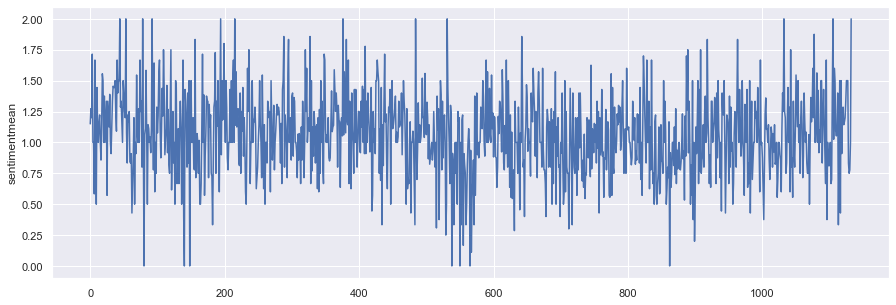

In [124]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(x=np.arange(0,1133,1), y= df.sentimentmean)

<AxesSubplot:ylabel='BTC-USDDirectionmean'>

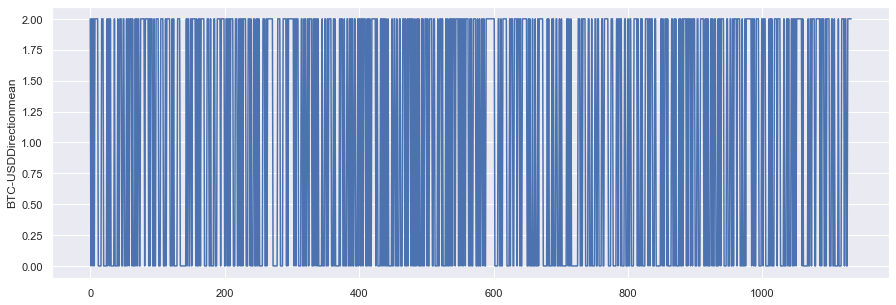

In [125]:
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(x=np.arange(0,1133,1), y= df['BTC-USDDirectionmean'])

In [126]:
TARGET = "BTC-USDDirectionmean"
#columns_predictors = ['combined mean']
#columns_predictors = ['negativemean','neutralmean','positivemean']
columns_predictors = ['sentimentmean']

df = df[df[TARGET]!= 1] # remove data points when there is no price change
df[TARGET].replace(2,1, inplace=True)  # Replace label 2 with 1
df = df[columns_predictors+[TARGET]].dropna(how='any') # drop na values


X = df[columns_predictors]
y = df[TARGET]
y.unique()

array([1., 0.])

<AxesSubplot:xlabel='BTC-USDDirectionmean', ylabel='Count'>

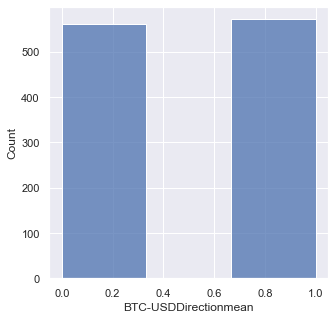

In [127]:
# check for balance data
# labels are balanced i.e equal split of inc and dec.
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(data=y, bins=3)

<AxesSubplot:ylabel='Count'>

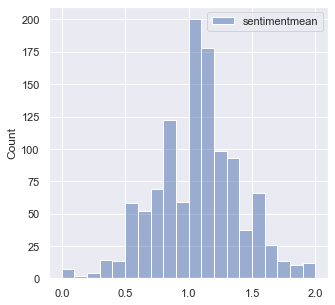

In [128]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(5,5)})
sns.histplot(data=X, bins = 20)

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10086, shuffle=False)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (849, 1)
X_test.shape: (284, 1)
y_train.shape: (849,)
y_test.shape: (284,)


In [118]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score, f1_score

def classification_metric(y_test,y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    print("accuracy_score %.4f" % accuracy)
    # precision
    print("precision_score %.4f"% precision_score(y_test,y_pred))
    # recall
    print("recall_score %.4f"% recall_score(y_test,y_pred))
    # F-1 score
    print("f1_score %.4f"% f1_score(y_test,y_pred))
    # Confusion Matrix
    print(confusion_matrix(y_test,y_pred))
    # Classification Report
    #print(classification_report(y_test,y_pred))
    return None

def model_evaluation(model,X_train,y_train,X_test,y_test):
    model = model.fit(X_train,y_train)
    # training accuracy
    print('Evaluation for Train Data')
    classification_metric(y_train,model.predict(X_train))

    #testing accuracy
    print('Evaluation for Test Data')
    classification_metric(y_test,model.predict(X_test))
    return None

# SVM Model (Linear Model)

In [109]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
# defining parameter range

polynomial_svm_clf = Pipeline(steps=[
        ("poly_features", PolynomialFeatures()),
        ("svm_clf", SVC(random_state=18886))
    ])

param_grid = {'poly_features__degree':[1,2,3],
            'svm_clf__C': [0.1, 1, 10, 100, 1000],
            'svm_clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'svm_clf__degree':[1,2,3],
            'svm_clf__kernel': ['linear','rbf','poly','sigmoid']}

grid = GridSearchCV(polynomial_svm_clf, param_grid, cv = 3, verbose = 1, n_jobs=2)


# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('svm_clf', SVC(random_state=18886))]),
             n_jobs=2,
             param_grid={'poly_features__degree': [1, 2, 3],
                         'svm_clf__C': [0.1, 1, 10, 100, 1000],
                         'svm_clf__degree': [1, 2, 3],
                         'svm_clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svm_clf__kernel': ['linear', 'rbf', 'poly',
                                             'sigmoid']},
             verbose=1)

In [110]:
svm = grid.best_estimator_
grid.best_params_

{'poly_features__degree': 3,
 'svm_clf__C': 10,
 'svm_clf__degree': 1,
 'svm_clf__gamma': 0.1,
 'svm_clf__kernel': 'rbf'}

In [119]:
model_evaluation(svm,X_train,y_train,X_test,y_test)

Evaluation for Train Data
accuracy_score 0.5371
precision_score 0.5253
recall_score 0.6667
f1_score 0.5876
[[176 253]
 [140 280]]
Evaluation for Test Data
accuracy_score 0.5106
precision_score 0.5341
recall_score 0.6225
f1_score 0.5749
[[51 82]
 [57 94]]
